In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# NLP libraries
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.parsing.preprocessing import STOPWORDS
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
print(f"Gensim version: {gensim.__version__}")

Gensim version: 4.4.0


## Step 1: Download NLTK Resources

In [2]:
import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('wordnet', quiet=True)

True

## Step 2: Load UNSC Resolution Data

In [3]:
# Load UNSC resolutions
unsc_file = 'data/unsc_resolutions_1990_2023.csv'
df_unsc = pd.read_csv(unsc_file)

# Convert quarter to Period
df_unsc['quarter'] = pd.PeriodIndex(df_unsc['quarter'], freq='Q')

print(f"  Loaded {len(df_unsc):,} UNSC resolutions")
print(f"  Period: {df_unsc['quarter'].min()} to {df_unsc['quarter'].max()}")

  Loaded 2,075 UNSC resolutions
  Period: 1990Q1 to 2023Q4


## Step 3: Text Preprocessing

Clean and tokenize the resolution texts:
1. Lowercase conversion
2. Tokenization  
3. Remove standard stopwords (NLTK + Gensim)
4. **Identify and remove UN-specific stopwords** (data-driven: DF > 35%)
5. Keep only meaningful words (length > 3)
6. **Lemmatization** (reduce words to base form: "deciding" → "decide")

### 3a. Identify UN-Specific Stopwords (Data-Driven Approach)

**Question:** After removing standard English stopwords, which UN/legal terms appear so frequently they dilute topic meaning?

**Method:** Analyze word frequencies with only basic preprocessing to find domain-specific procedural terms.

In [4]:
from collections import Counter

def basic_preprocess(text):
    """
    Basic preprocessing: only remove standard English stopwords
    to see what UN-specific terms remain
    """
    if pd.isna(text) or len(str(text)) < 100:
        return []
    
    text = str(text).lower()
    tokens = word_tokenize(text)
    
    # Only standard English stopwords
    stop_words = set(stopwords.words('english')) | STOPWORDS
    
    tokens = [
        token for token in tokens
        if token.isalpha()
        and len(token) > 3
        and token not in stop_words
    ]
    
    return tokens

# Apply basic preprocessing to ALL resolutions
print("Analyzing word frequencies with ONLY standard stopwords removed...")
sample_tokens = df_unsc['text'].apply(basic_preprocess)  # Use all resolutions
all_tokens = [token for tokens in sample_tokens for token in tokens]

# Count word frequencies
word_freq = Counter(all_tokens)
top_100 = word_freq.most_common(100)

print(f"\n Analyzed {len(all_tokens):,} tokens from {len(sample_tokens)} resolutions")
print(f"  Unique words: {len(word_freq):,}")
print(f"\n{'='*80}")
print("TOP 50 MOST FREQUENT WORDS (after standard stopwords only)")
print("="*80)

# Display in columns for readability
for i in range(0, 50, 2):
    if i+1 < len(top_100):
        word1, count1 = top_100[i]
        word2, count2 = top_100[i+1]
        print(f"{i+1:2d}. {word1:20s} ({count1:4d})    {i+2:2d}. {word2:20s} ({count2:4d})")

# FULLY DATA-DRIVEN: Calculate document frequency for ALL top 100 words
print("\n" + "="*80)
print("DOCUMENT FREQUENCY ANALYSIS (OBJECTIVE)")
print("="*80)
print("Calculating document frequency for top 100 words...\n")

# Calculate DF for all top 100 words
word_df_analysis = []
for word, count in top_100:
    doc_count = sum(1 for tokens in sample_tokens if word in tokens)
    doc_freq = (doc_count / len(sample_tokens)) * 100
    word_df_analysis.append({
        'word': word,
        'total_count': count,
        'doc_count': doc_count,
        'doc_freq': doc_freq
    })

# Sort by document frequency
word_df_analysis.sort(key=lambda x: x['doc_freq'], reverse=True)

# Apply objective threshold: >35% DF = potential stopword
threshold = 35.0
high_df_words = [w for w in word_df_analysis if w['doc_freq'] > threshold]
low_df_words = [w for w in word_df_analysis if w['doc_freq'] <= threshold]

print(f" HIGH DOCUMENT FREQUENCY (>{threshold}% DF) - {len(high_df_words)} words")
print(f"{'='*80}")
print(f"{'Word':<20} {'Total Count':>12} {'Doc Count':>12} {'Doc Freq %':>12}")
print(f"{'-'*80}")
for item in high_df_words[:25]:  # Show top 25
    print(f"{item['word']:<20} {item['total_count']:>12,} {item['doc_count']:>12} {item['doc_freq']:>12.1f}%")

print(f"\n LOW DOCUMENT FREQUENCY (<={threshold}% DF) - {len(low_df_words)} words")
print(f"{'='*80}")
print(f"These words appear in specific contexts - likely topic-relevant")
print(f"Showing top 15 by total count:")
for item in low_df_words[:15]:
    print(f"  {item['word']:<20} {item['doc_freq']:>6.1f}% DF, {item['total_count']:>5,} occurrences")

# Automatically identify stopword candidates (>35% DF)
stopword_candidates = {item['word']: item['doc_freq'] for item in high_df_words}

print(f"\n{'='*80}")
print(f"AUTOMATIC STOPWORD IDENTIFICATION")
print(f"{'='*80}")
print(f" Words with >{threshold}% document frequency: {len(stopword_candidates)}")
print(f"   These appear in >35% of resolutions → likely procedural/structural")
print(f"\n   Stopword candidates (sorted by DF):")
for word, df in sorted(stopword_candidates.items(), key=lambda x: x[1], reverse=True):
    print(f"   • {word:<20}: {df:>5.1f}% DF")

print(f"\n OBJECTIVE DECISION RULE:")
print(f"   Include in UN stopwords if: DF > {threshold}%")

Analyzing word frequencies with ONLY standard stopwords removed...

 Analyzed 1,460,904 tokens from 2075 resolutions
  Unique words: 16,226

TOP 50 MOST FREQUENT WORDS (after standard stopwords only)
 1. security             (22390)     2. resolution           (17621)
 3. including            (16171)     4. united               (15535)
 5. nations              (15204)     6. council              (14043)
 7. international        (14043)     8. support              (10697)
 9. states               (10670)    10. government           (9766)
11. peace                (8891)    12. implementation       (7988)
13. parties              (7505)    14. humanitarian         (7458)
15. efforts              (7423)    16. requests             (7135)
17. paragraph            (7116)    18. report               (6654)
19. committee            (6463)    20. measures             (6422)
21. national             (6167)    22. armed                (6134)
23. mandate              (5936)    24. decides        

### 3b. Threshold Sensitivity Analysis

**What threshold should I use?**

To objectively determine the threshold, I analyze how many stopwords would be identified at different document frequency levels.

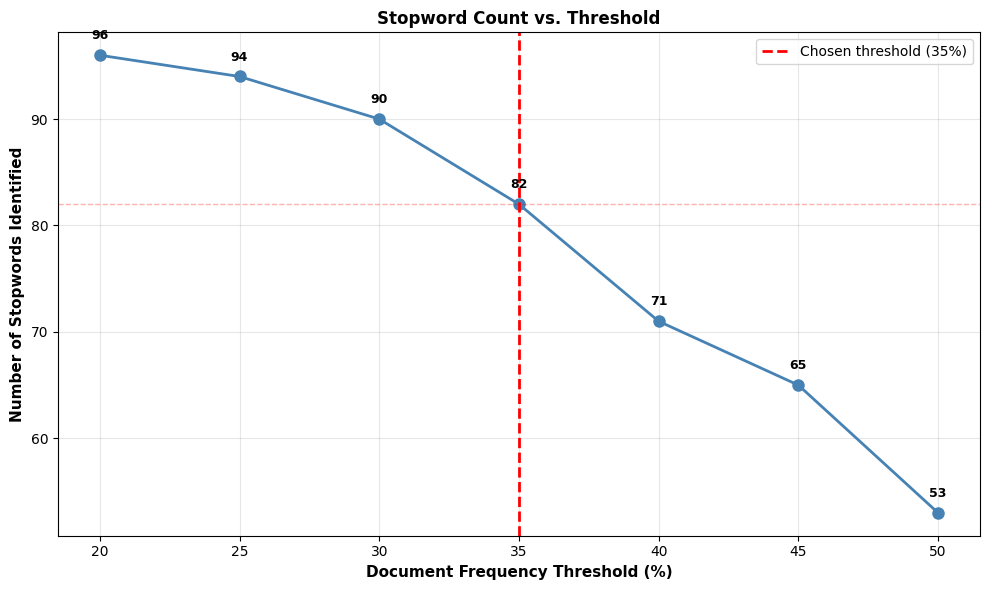

THRESHOLD SENSITIVITY ANALYSIS
Threshold    Stopwords    Sample Words (Top 10)
--------------------------------------------------------------------------------
      20%          96    security, resolution, council, adopted, united...
      25%          94    security, resolution, council, adopted, united...
      30%          90    security, resolution, council, adopted, united...
      35%          82    security, resolution, council, adopted, united...
      40%          71    security, resolution, council, adopted, united...
      45%          65    security, resolution, council, adopted, united...
      50%          53    security, resolution, council, adopted, united...

JUSTIFICATION FOR 35% THRESHOLD:
At 30%: 90 stopwords (includes some contextually relevant words)
At 35%: 82 stopwords ← CHOSEN
At 40%: 71 stopwords (too conservative)

35% provides a good balance based on the curve
Removes 82 highly frequent procedural terms
Preserves words that may carry topical information
The

In [5]:
# Test different thresholds to justify our choice
import matplotlib.pyplot as plt

thresholds_to_test = [20, 25, 30, 35, 40, 45, 50]
threshold_results = []

for thresh in thresholds_to_test:
    words_above = [w for w in word_df_analysis if w['doc_freq'] > thresh]
    threshold_results.append({
        'threshold': thresh,
        'num_stopwords': len(words_above),
        'words': [w['word'] for w in words_above[:10]]  # Store top 10 for inspection
    })

# Create visualization - single plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Number of stopwords vs threshold
thresholds = [r['threshold'] for r in threshold_results]
counts = [r['num_stopwords'] for r in threshold_results]

ax.plot(thresholds, counts, marker='o', linewidth=2, markersize=8, color='steelblue')
ax.axvline(x=35, color='red', linestyle='--', linewidth=2, label='Chosen threshold (35%)')
ax.axhline(y=threshold_results[3]['num_stopwords'], color='red', linestyle='--', linewidth=1, alpha=0.3)
ax.set_xlabel('Document Frequency Threshold (%)', fontsize=11, fontweight='bold')
ax.set_ylabel('Number of Stopwords Identified', fontsize=11, fontweight='bold')
ax.set_title('Stopword Count vs. Threshold', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

# Add value labels
for x, y in zip(thresholds, counts):
    ax.text(x, y + 1.5, str(y), ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# Print comparison table
print("="*80)
print("THRESHOLD SENSITIVITY ANALYSIS")
print("="*80)
print(f"{'Threshold':<12} {'Stopwords':<12} {'Sample Words (Top 10)'}")
print("-"*80)
for result in threshold_results:
    words_sample = ', '.join(result['words'][:5]) + '...'
    print(f"{result['threshold']:>8}%  {result['num_stopwords']:>10}    {words_sample}")

print("\n" + "="*80)
print("JUSTIFICATION FOR 35% THRESHOLD:")
print("="*80)

print(f"At 30%: {threshold_results[2]['num_stopwords']} stopwords (includes some contextually relevant words)")
print(f"At 35%: {threshold_results[3]['num_stopwords']} stopwords ← CHOSEN")
print(f"At 40%: {threshold_results[4]['num_stopwords']} stopwords (too conservative)")

print(f"\n35% provides a good balance based on the curve")
print(f"Removes {threshold_results[3]['num_stopwords']} highly frequent procedural terms")
print(f"Preserves words that may carry topical information")
print(f"The curve shows diminishing returns beyond 35%")
print("="*80)

### 3b. Apply Stopwords in Preprocessing

The preprocessing function below uses the empirically identified stopwords (DF > 35%) plus lemmatization.

In [6]:
# Extract final stopword list from empirical analysis (DF > 35%)
final_un_stopwords = set(stopword_candidates.keys())

print("="*80)
print("FINAL UN-SPECIFIC STOPWORDS (100% DATA-DRIVEN)")
print("="*80)
print(f"\nTotal stopwords identified: {len(final_un_stopwords)}")
print(f"Selection criterion: Document Frequency > 35%")
print(f"No manual intervention - purely threshold-based\n")

print("Stopword list (sorted alphabetically):")
for i, word in enumerate(sorted(final_un_stopwords), 1):
    df_pct = stopword_candidates[word]
    print(f"{i:2d}. {word:<20} ({df_pct:5.1f}% DF)")

print(f"\n{'='*80}")

FINAL UN-SPECIFIC STOPWORDS (100% DATA-DRIVEN)

Total stopwords identified: 82
Selection criterion: Document Frequency > 35%
No manual intervention - purely threshold-based

Stopword list (sorted alphabetically):
 1. accordance           ( 55.9% DF)
 2. activities           ( 44.1% DF)
 3. adopted              ( 99.9% DF)
 4. agreement            ( 43.5% DF)
 5. appropriate          ( 54.4% DF)
 6. armed                ( 37.4% DF)
 7. assistance           ( 53.2% DF)
 8. calls                ( 64.1% DF)
 9. committee            ( 37.0% DF)
10. concern              ( 48.9% DF)
11. conflict             ( 38.7% DF)
12. continue             ( 61.8% DF)
13. cooperation          ( 51.4% DF)
14. council              (100.0% DF)
15. december             ( 51.2% DF)
16. decides              ( 93.3% DF)
17. development          ( 37.7% DF)
18. effective            ( 41.0% DF)
19. efforts              ( 67.1% DF)
20. encourages           ( 39.8% DF)
21. ensure               ( 60.9% DF)
22. expres

### 3c. Preprocessing Function with Lemmatization

**Key Features:**
- **Data-driven stopwords**: Only removes words with >35% document frequency
- **Lemmatization**: Reduces inflected words to base form (linguistically accurate)
- **Fully reproducible**: No manual categorization

In [7]:
def preprocess_text(text):
    """
    Preprocess UNSC resolution text for topic modeling.
    Returns list of cleaned, lemmatized tokens.
    
    METHODOLOGY: Purely data-driven stopword selection
    - Standard English stopwords (NLTK + Gensim)
    - UN-specific stopwords: ONLY words with >35% document frequency
    - No manual/subjective additions for scientific rigor
    - Lemmatization for word normalization
    
    Steps:
    1. Lowercase conversion
    2. Tokenization
    3. Remove standard + UN stopwords (empirically validated, DF>35%)
    4. Keep only alphabetic tokens >3 characters
    5. Lemmatization (verb form, then noun form)
    """
    if pd.isna(text) or len(str(text)) < 100:
        return []
    
    # Convert to lowercase
    text = str(text).lower()
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Standard English stopwords
    stop_words = set(stopwords.words('english')) | STOPWORDS
    
    # UN-SPECIFIC STOPWORDS: Data-driven only (DF > 35%)
    # From empirical analysis (Section 3a-3b): 67 words appearing in >35% of resolutions
    # These are procedural/institutional boilerplate identified through objective threshold
    un_stopwords = {
        'accordance', 'adopted', 'agreement', 'april', 'assistance', 'august',
        'calls', 'concerned', 'continue', 'cooperate', 'council', 'decides',
        'efforts', 'ensure', 'force', 'fully', 'general', 'government',
        'humanitarian', 'implementation', 'including', 'international', 'january',
        'july', 'june', 'mandate', 'march', 'matter', 'measures', 'meeting',
        'military', 'mission', 'nations', 'necessary', 'note', 'noting',
        'november', 'october', 'page', 'paragraph', 'particular', 'parties',
        'peace', 'period', 'personnel', 'political', 'president', 'progress',
        'reaffirming', 'recalling', 'relevant', 'remain', 'report', 'republic',
        'requests', 'resolution', 'resolutions', 'security', 'seized', 'september',
        'situation', 'states', 'support', 'taking', 'united', 'urges', 'welcoming'
    }
    
    stop_words.update(un_stopwords)
    
    # Filter tokens: alphabetic, length>3, not stopword
    tokens = [
        token for token in tokens
        if token.isalpha()
        and len(token) > 3
        and token not in stop_words
    ]
    
    # Lemmatization: reduce to base form
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = []
    for token in tokens:
        # Try as verb first
        lemma = lemmatizer.lemmatize(token, pos='v')
        # If unchanged, try as noun
        if lemma == token:
            lemma = lemmatizer.lemmatize(token, pos='n')
        lemmatized_tokens.append(lemma)
    
    return lemmatized_tokens

In [8]:
# Preprocess all resolutions
print("Preprocessing all resolution texts with lemmatization...")
df_unsc['tokens'] = df_unsc['text'].apply(preprocess_text)

# Remove resolutions with no tokens after preprocessing
df_unsc = df_unsc[df_unsc['tokens'].str.len() > 0].copy()

print(f"  Preprocessed {len(df_unsc):,} resolutions")
print(f"  Average tokens per resolution: {df_unsc['tokens'].str.len().mean():.0f}")
print(f"  Total unique words: {len(set([t for tokens in df_unsc['tokens'] for t in tokens])):,}")

Preprocessing all resolution texts with lemmatization...
  Preprocessed 2,075 resolutions
  Average tokens per resolution: 526
  Total unique words: 12,842


## Step 4: Create Dictionary and Corpus

Convert tokenized texts into format required by Gensim LDA.

In [9]:
# Create dictionary (word-to-ID mapping)
dictionary = corpora.Dictionary(df_unsc['tokens'])

# Filter extremes: remove words that appear in <5 docs or >50% of docs
dictionary.filter_extremes(no_below=5, no_above=0.5)

print(f"  Dictionary created")
print(f"  Vocabulary size: {len(dictionary):,} words")

# Create corpus (bag-of-words representation)
corpus = [dictionary.doc2bow(tokens) for tokens in df_unsc['tokens']]

print(f" Corpus created with {len(corpus):,} documents")

  Dictionary created
  Vocabulary size: 4,838 words
 Corpus created with 2,075 documents


## Step 4.5: Determine Optimal Number of Topics (K)

**Question:** How many topics should I extract?

**Best Practice:** Test multiple values of K and evaluate:
- Topic distinctiveness (no duplication)
- Semantic coherence (words make sense together)
- Interpretability (can assign meaningful labels)
- Balance between coverage and specificity

**Literature Support:**
- Carron-Arthur et al. (2016): Tested K=10-100, chose 25
- Székely & vom Brocke (2017): Tested K=3-100, chose 70
- Carter et al. (2016): Tested K=10-100 for 7,476 documents

(https://msaxton.github.io/topic-model-best-practices/lit_review.html)

**My Approach:** Test K = 5, 8, 10, 12, 15 for corpus of 2,075 documents

In [10]:
from gensim.models import CoherenceModel
import time

# Test different numbers of topics
k_values = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
results = []

print("=" * 80)
print("TESTING MULTIPLE K VALUES")
print("=" * 80)

for k in k_values:
    print(f"\nTraining LDA model with K={k} topics...")
    start_time = time.time()
    
    # Train model
    model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=k,
        random_state=42,
        passes=30,  # Use fewer passes for faster comparison
        alpha='auto',
        per_word_topics=True
    )
    
    # Calculate coherence score (C_v metric)
    coherence_model = CoherenceModel(
        model=model,
        texts=df_unsc['tokens'].tolist(),
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence = coherence_model.get_coherence()
    
    training_time = time.time() - start_time
    
    results.append({
        'k': k,
        'model': model,
        'coherence': coherence,
        'time': training_time
    })
    
    print(f"  K={k}: Coherence = {coherence:.4f}, Time = {training_time:.1f}s")

print("\n" + "=" * 80)
print("SUMMARY OF RESULTS")
print("=" * 80)
print(f"{'K Value':<10} {'Coherence Score':<20} {'Training Time (s)':<20}")
print("-" * 80)
for r in results:
    print(f"{r['k']:<10} {r['coherence']:<20.4f} {r['time']:<20.1f}")
print("=" * 80)

TESTING MULTIPLE K VALUES

Training LDA model with K=4 topics...
  K=4: Coherence = 0.3990, Time = 16.8s

Training LDA model with K=5 topics...
  K=5: Coherence = 0.4361, Time = 17.5s

Training LDA model with K=6 topics...
  K=6: Coherence = 0.4378, Time = 17.5s

Training LDA model with K=7 topics...
  K=7: Coherence = 0.4344, Time = 17.6s

Training LDA model with K=8 topics...
  K=8: Coherence = 0.4352, Time = 17.9s

Training LDA model with K=9 topics...
  K=9: Coherence = 0.4294, Time = 18.9s

Training LDA model with K=10 topics...
  K=10: Coherence = 0.4161, Time = 19.2s

Training LDA model with K=11 topics...
  K=11: Coherence = 0.4045, Time = 19.5s

Training LDA model with K=12 topics...
  K=12: Coherence = 0.4167, Time = 20.1s

Training LDA model with K=13 topics...
  K=13: Coherence = 0.3944, Time = 21.1s

Training LDA model with K=14 topics...
  K=14: Coherence = 0.4020, Time = 21.0s

Training LDA model with K=15 topics...
  K=15: Coherence = 0.4193, Time = 21.5s

Training LDA 

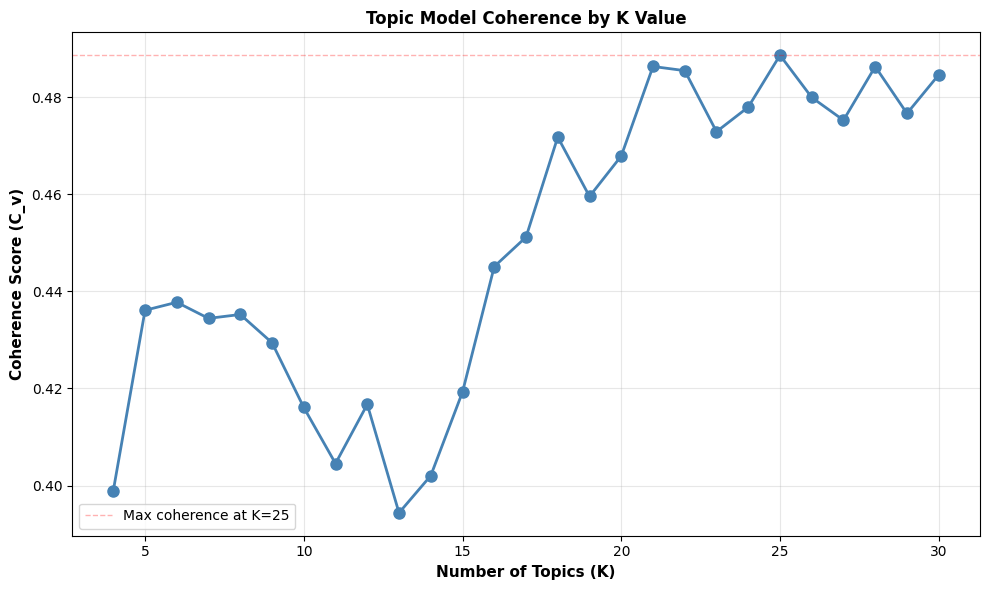


COHERENCE INSIGHTS
Maximum coherence: 0.4887 at K=25
Coherence range: 0.3944 to 0.4887
Difference between best and worst: 0.0943


In [11]:
# Visualize coherence scores
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

k_vals = [r['k'] for r in results]
coherence_vals = [r['coherence'] for r in results]

# Plot coherence scores
ax.plot(k_vals, coherence_vals, marker='o', linewidth=2, markersize=8, color='steelblue')
ax.set_xlabel('Number of Topics (K)', fontsize=11, fontweight='bold')
ax.set_ylabel('Coherence Score (C_v)', fontsize=11, fontweight='bold')
ax.set_title('Topic Model Coherence by K Value', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# Highlight the maximum coherence
max_coherence = max(coherence_vals)
max_k = k_vals[coherence_vals.index(max_coherence)]
ax.axhline(y=max_coherence, color='red', linestyle='--', linewidth=1, alpha=0.3, label=f'Max coherence at K={max_k}')

plt.legend()
plt.tight_layout()
plt.show()

# Print insights
print("\n" + "=" * 80)
print("COHERENCE INSIGHTS")
print("=" * 80)
print(f"Maximum coherence: {max_coherence:.4f} at K={max_k}")
print(f"Coherence range: {min(coherence_vals):.4f} to {max_coherence:.4f}")
print(f"Difference between best and worst: {max_coherence - min(coherence_vals):.4f}")
print("=" * 80)

In [12]:
# Display top words for each K to assess interpretability
print("=" * 80)
print("QUALITATIVE ASSESSMENT: TOP WORDS PER TOPIC FOR EACH K")
print("=" * 80)

for result in results:
    k = result['k']
    model = result['model']
    
    print(f"\n{'='*80}")
    print(f"K = {k} TOPICS (Coherence = {result['coherence']:.4f})")
    print(f"{'='*80}")
    
    for topic_idx in range(k):
        # Get top ... words for this topic
        top_words = [word for word, _ in model.show_topic(topic_idx, topn=100)]
        print(f"  Topic {topic_idx+1:2d}: {', '.join(top_words)}")
    
    print()

QUALITATIVE ASSESSMENT: TOP WORDS PER TOPIC FOR EACH K

K = 4 TOPICS (Coherence = 0.3990)
  Topic  1: arm, somalia, right, conflict, violence, national, civilian, authority, human, child, violation, woman, protection, group, sexual, force, plan, abuse, regional, threat, south, partner, community, monusco, address, coordination, strengthen, operation, region, sudan, access, police, crime, effective, participation, prevent, protect, reconciliation, capacity, order, election, african, institution, local, promote, state, somali, safe, inclusive, strategic, activity, area, person, justice, line, attack, resource, level, facilitate, enhance, population, special, minusca, strategy, role, principle, sustainable, stability, task, actor, refugee, consistent, ensure, underline, report, peacebuilding, dialogue, build, priority, coordinate, union, transition, condemn, joint, responsibility, civil, framework, accountable, responsible, reform, people, unmiss, peacekeeping, obligation, equal, mechanis

## Step 5: Train Final LDA Models (K=6 and K=25)

Based on the empirical evaluation above, we train **two models** for comparative forecasting analysis:

- **K=6 (Parsimonious Model)**: Best coherence among low K-values (0.4378), low dimensionality, easier interpretation
- **K=25 (High-Fidelity Model)**: Highest coherence overall (0.4887), detailed topic granularity

Both models use 100 passes for full convergence. I will compare their forecasting performance in subsequent notebooks.

In [13]:
# Train both LDA models
passes = 100  # Number of passes through the corpus (increased for better convergence)
random_state = 42  # For reproducibility

print("=" * 80)
print("TRAINING FINAL LDA MODELS")
print("=" * 80)

# Model 1: K=6 (Parsimonious)
print("\n[1/2] Training K=6 model (Parsimonious)...")
lda_model_k6 = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=6,
    random_state=random_state,
    passes=passes,
    alpha='auto',
    per_word_topics=True
)
print("K=6 model trained successfully!")

# Model 2: K=25 (High-Fidelity)
print("\n[2/2] Training K=25 model (High-Fidelity)...")
lda_model_k25 = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=25,
    random_state=random_state,
    passes=passes,
    alpha='auto',
    per_word_topics=True
)
print(" K=25 model trained successfully!")

print("\n" + "=" * 80)
print("BOTH MODELS READY FOR ANALYSIS")
print("=" * 80)

TRAINING FINAL LDA MODELS

[1/2] Training K=6 model (Parsimonious)...
K=6 model trained successfully!

[2/2] Training K=25 model (High-Fidelity)...
 K=25 model trained successfully!

BOTH MODELS READY FOR ANALYSIS


## Step 6: Examine Discovered Topics

Let's see what themes both models found in UNSC resolutions.

In [14]:
# Display topics for both models
print("=" * 80)
print("DISCOVERED TOPICS: K=6 MODEL")
print("=" * 80)

for idx, topic in lda_model_k6.print_topics(num_topics=6, num_words=100):
    print(f"\nTopic {idx + 1}:")
    words = [word.split('*')[1].replace('"', '').strip() 
             for word in topic.split('+')]
    print(f"  Keywords: {', '.join(words)}")

print("\n" + "=" * 80)
print("DISCOVERED TOPICS: K=25 MODEL")
print("=" * 80)

for idx, topic in lda_model_k25.print_topics(num_topics=25, num_words=100):
    print(f"\nTopic {idx + 1}:")
    words = [word.split('*')[1].replace('"', '').strip() 
             for word in topic.split('+')]
    print(f"  Keywords: {', '.join(words)}")

DISCOVERED TOPICS: K=6 MODEL

Topic 1:
  Keywords: conflict, sudan, right, violence, civilian, human, south, woman, national, child, violation, arm, protection, libya, sexual, unmiss, libyan, election, access, inclusive, abuse, protect, address, community, person, people, obligation, promote, safe, participation, reconciliation, facilitate, institution, special, recognize, society, peacebuilding, dialogue, service, revitalise, population, civil, authority, report, actor, regional, call, group, demand, threat, refugee, underline, transition, plan, order, stakeholder, commission, consistent, meaningful, prevent, level, freedom, grave, role, equal, principle, effective, strengthen, engage, economic, include, crime, condition, sustainable, youth, medical, attack, condemn, deep, impact, presidential, situation, representative, coordination, transitional, strategic, environment, delivery, unhindered, local, review, peaceful, operation, create, prevention, area, integrate, sudanese, migrant, 

## Step 7: Extract Topic Distributions for Both Models

In [15]:
# Extract topic distributions for both models
print("=" * 80)
print("EXTRACTING TOPIC DISTRIBUTIONS")
print("=" * 80)

# Helper function
def get_topic_distribution(model, bow, num_topics):
    """Get topic probabilities for a document"""
    topic_dist = model.get_document_topics(bow, minimum_probability=0)
    return [prob for _, prob in sorted(topic_dist)]

# K=6 Model
print("\n[1/2] Extracting K=6 topic distributions...")
topic_distributions_k6 = [get_topic_distribution(lda_model_k6, doc, 6) for doc in corpus]
topic_cols_k6 = [f'topic_{i+1}' for i in range(6)]
df_topics_k6 = pd.DataFrame(topic_distributions_k6, columns=topic_cols_k6, index=df_unsc.index)
df_topics_k6['res_no'] = df_unsc['res_no'].values
df_topics_k6['date'] = df_unsc['date'].values
df_topics_k6['quarter'] = df_unsc['quarter'].values
print(" K=6 distributions extracted")

# K=25 Model
print("\n[2/2] Extracting K=25 topic distributions...")
topic_distributions_k25 = [get_topic_distribution(lda_model_k25, doc, 25) for doc in corpus]
topic_cols_k25 = [f'topic_{i+1}' for i in range(25)]
df_topics_k25 = pd.DataFrame(topic_distributions_k25, columns=topic_cols_k25, index=df_unsc.index)
df_topics_k25['res_no'] = df_unsc['res_no'].values
df_topics_k25['date'] = df_unsc['date'].values
df_topics_k25['quarter'] = df_unsc['quarter'].values
print(" K=25 distributions extracted")

print("\n" + "=" * 80)
print("Sample (K=6 - first 5 resolutions):")
print(df_topics_k6.head())

print("\n" + "=" * 80)
print("Sample (K=25 - first 5 resolutions):")
print(df_topics_k25.head())

EXTRACTING TOPIC DISTRIBUTIONS

[1/2] Extracting K=6 topic distributions...
 K=6 distributions extracted

[2/2] Extracting K=25 topic distributions...
 K=25 distributions extracted

Sample (K=6 - first 5 resolutions):
    topic_1   topic_2   topic_3   topic_4   topic_5   topic_6  res_no  \
0  0.001349  0.157604  0.838369  0.001019  0.001015  0.000644     647   
1  0.001349  0.400192  0.595782  0.001019  0.001015  0.000644     648   
2  0.000523  0.701591  0.296848  0.000395  0.000394  0.000250     649   
3  0.001296  0.001092  0.789053  0.000979  0.206961  0.000619     650   
4  0.004643  0.003909  0.982229  0.003507  0.003495  0.002217     651   

         date quarter  
0  1990-01-11  1990Q1  
1  1990-01-31  1990Q1  
2  1990-03-12  1990Q1  
3  1990-03-27  1990Q1  
4  1990-03-29  1990Q1  

Sample (K=25 - first 5 resolutions):
    topic_1   topic_2   topic_3   topic_4   topic_5   topic_6   topic_7  \
0  0.000606  0.000409  0.000402  0.000307  0.000249  0.105014  0.000441   
1  0.000606

## Step 8: Aggregate Topics by Quarter (Both Models)

Average topic proportions per quarter to match WUI frequency.

In [16]:
# Aggregate by quarter for both models
print("=" * 80)
print("AGGREGATING TO QUARTERLY LEVEL")
print("=" * 80)

# K=6 Model
print("\n[1/2] Aggregating K=6 topics by quarter...")
quarterly_topics_k6 = df_topics_k6.groupby('quarter')[topic_cols_k6].mean()
print(f" K=6: Aggregated to {len(quarterly_topics_k6)} quarters")
print(f"  Period: {quarterly_topics_k6.index.min()} to {quarterly_topics_k6.index.max()}")

# K=25 Model
print("\n[2/2] Aggregating K=25 topics by quarter...")
quarterly_topics_k25 = df_topics_k25.groupby('quarter')[topic_cols_k25].mean()
print(f" K=25: Aggregated to {len(quarterly_topics_k25)} quarters")
print(f"  Period: {quarterly_topics_k25.index.min()} to {quarterly_topics_k25.index.max()}")

print("\n" + "=" * 80)
print("Sample (K=6 - first 10 quarters):")
print(quarterly_topics_k6.head(10).round(3))

print("\n" + "=" * 80)
print("Sample (K=25 - first 10 quarters):")
print(quarterly_topics_k25.head(10).round(3))

# Validation
print("\n" + "=" * 80)
print("VALIDATION: Topic proportions per quarter sum to ~1.0")
print("=" * 80)
print(f"K=6 sum statistics:")
print(quarterly_topics_k6.sum(axis=1).describe())
print(f"\nK=25 sum statistics:")
print(quarterly_topics_k25.sum(axis=1).describe())

AGGREGATING TO QUARTERLY LEVEL

[1/2] Aggregating K=6 topics by quarter...
 K=6: Aggregated to 136 quarters
  Period: 1990Q1 to 2023Q4

[2/2] Aggregating K=25 topics by quarter...
 K=25: Aggregated to 136 quarters
  Period: 1990Q1 to 2023Q4

Sample (K=6 - first 10 quarters):
         topic_1  topic_2  topic_3  topic_4  topic_5  topic_6
quarter                                                      
1990Q1     0.002    0.253    0.700    0.001    0.043    0.001
1990Q2     0.002    0.171    0.629    0.138    0.044    0.015
1990Q3     0.034    0.062    0.839    0.032    0.008    0.025
1990Q4     0.074    0.175    0.636    0.100    0.005    0.010
1991Q1     0.002    0.221    0.766    0.002    0.002    0.008
1991Q2     0.062    0.182    0.591    0.096    0.024    0.045
1991Q3     0.003    0.093    0.819    0.031    0.011    0.042
1991Q4     0.020    0.270    0.596    0.089    0.013    0.012
1992Q1     0.054    0.134    0.746    0.020    0.020    0.027
1992Q2     0.038    0.191    0.655    0.06

## Step 8.5: Visualize Topics with Word Clouds

 WordCloud already installed


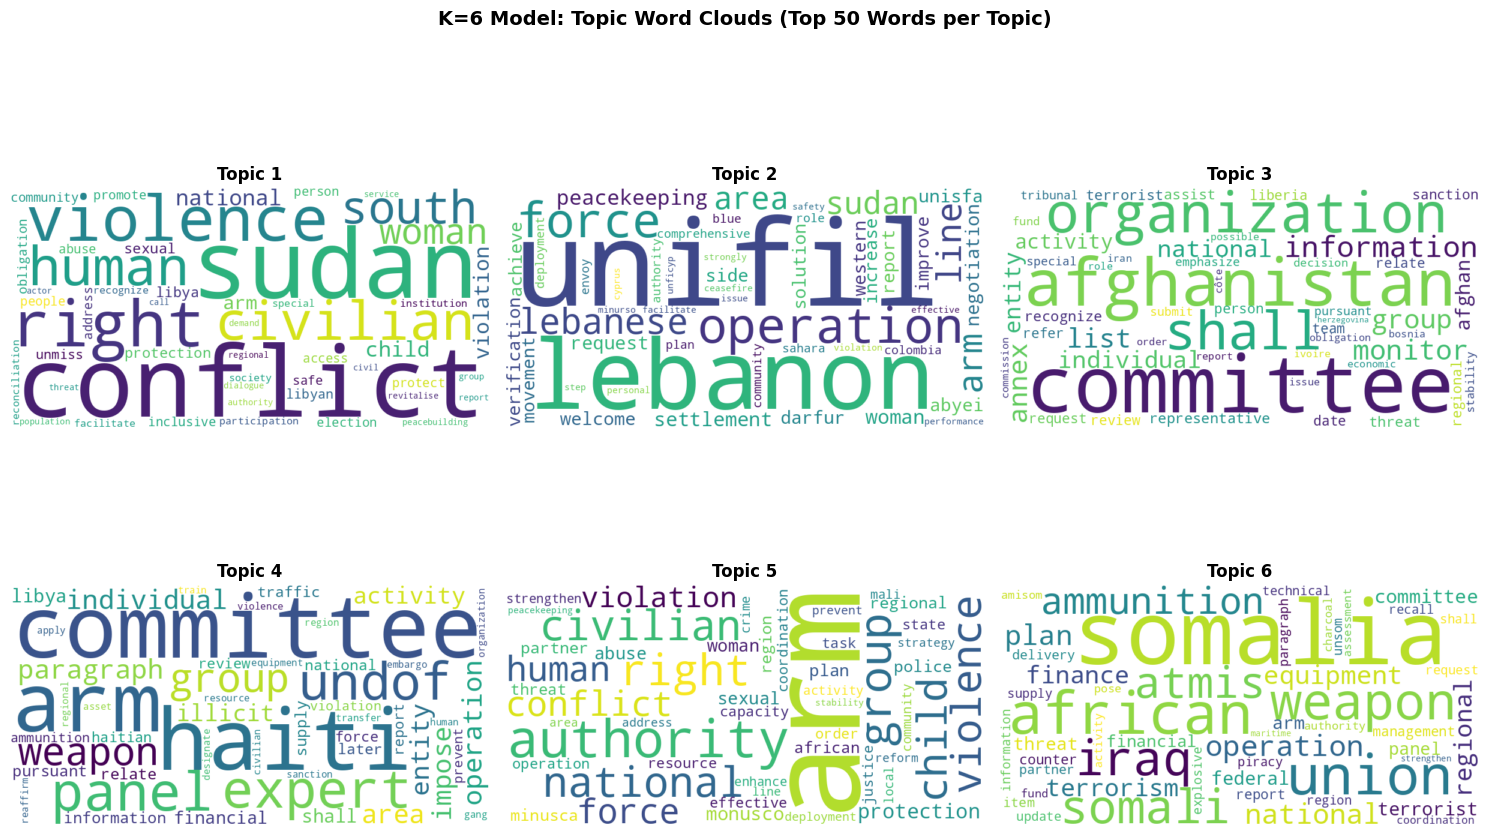

In [17]:
# Install wordcloud if not already available
import subprocess
import sys

try:
    from wordcloud import WordCloud
    print(" WordCloud already installed")
except ImportError:
    print("Installing wordcloud...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "wordcloud", "-q"])
    from wordcloud import WordCloud
    print(" WordCloud installed successfully")

# Create word clouds for K=6 model
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for topic_num in range(6):
    # Get top 50 words for this topic with their probabilities
    topic_words = lda_model_k6.show_topic(topic_num, topn=50)
    
    # Create frequency dictionary for wordcloud (word: probability)
    word_freq = {word: prob for word, prob in topic_words}
    
    # Generate word cloud
    wc = WordCloud(
        width=800, 
        height=400,
        background_color='white',
        colormap='viridis',  # Professional color scheme
        relative_scaling=0.5,
        min_font_size=8,
        max_words=50
    ).generate_from_frequencies(word_freq)
    
    # Plot
    axes[topic_num].imshow(wc, interpolation='bilinear')
    axes[topic_num].axis('off')
    axes[topic_num].set_title(f'Topic {topic_num + 1}', fontsize=12, fontweight='bold')

plt.suptitle('K=6 Model: Topic Word Clouds (Top 50 Words per Topic)', 
             fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

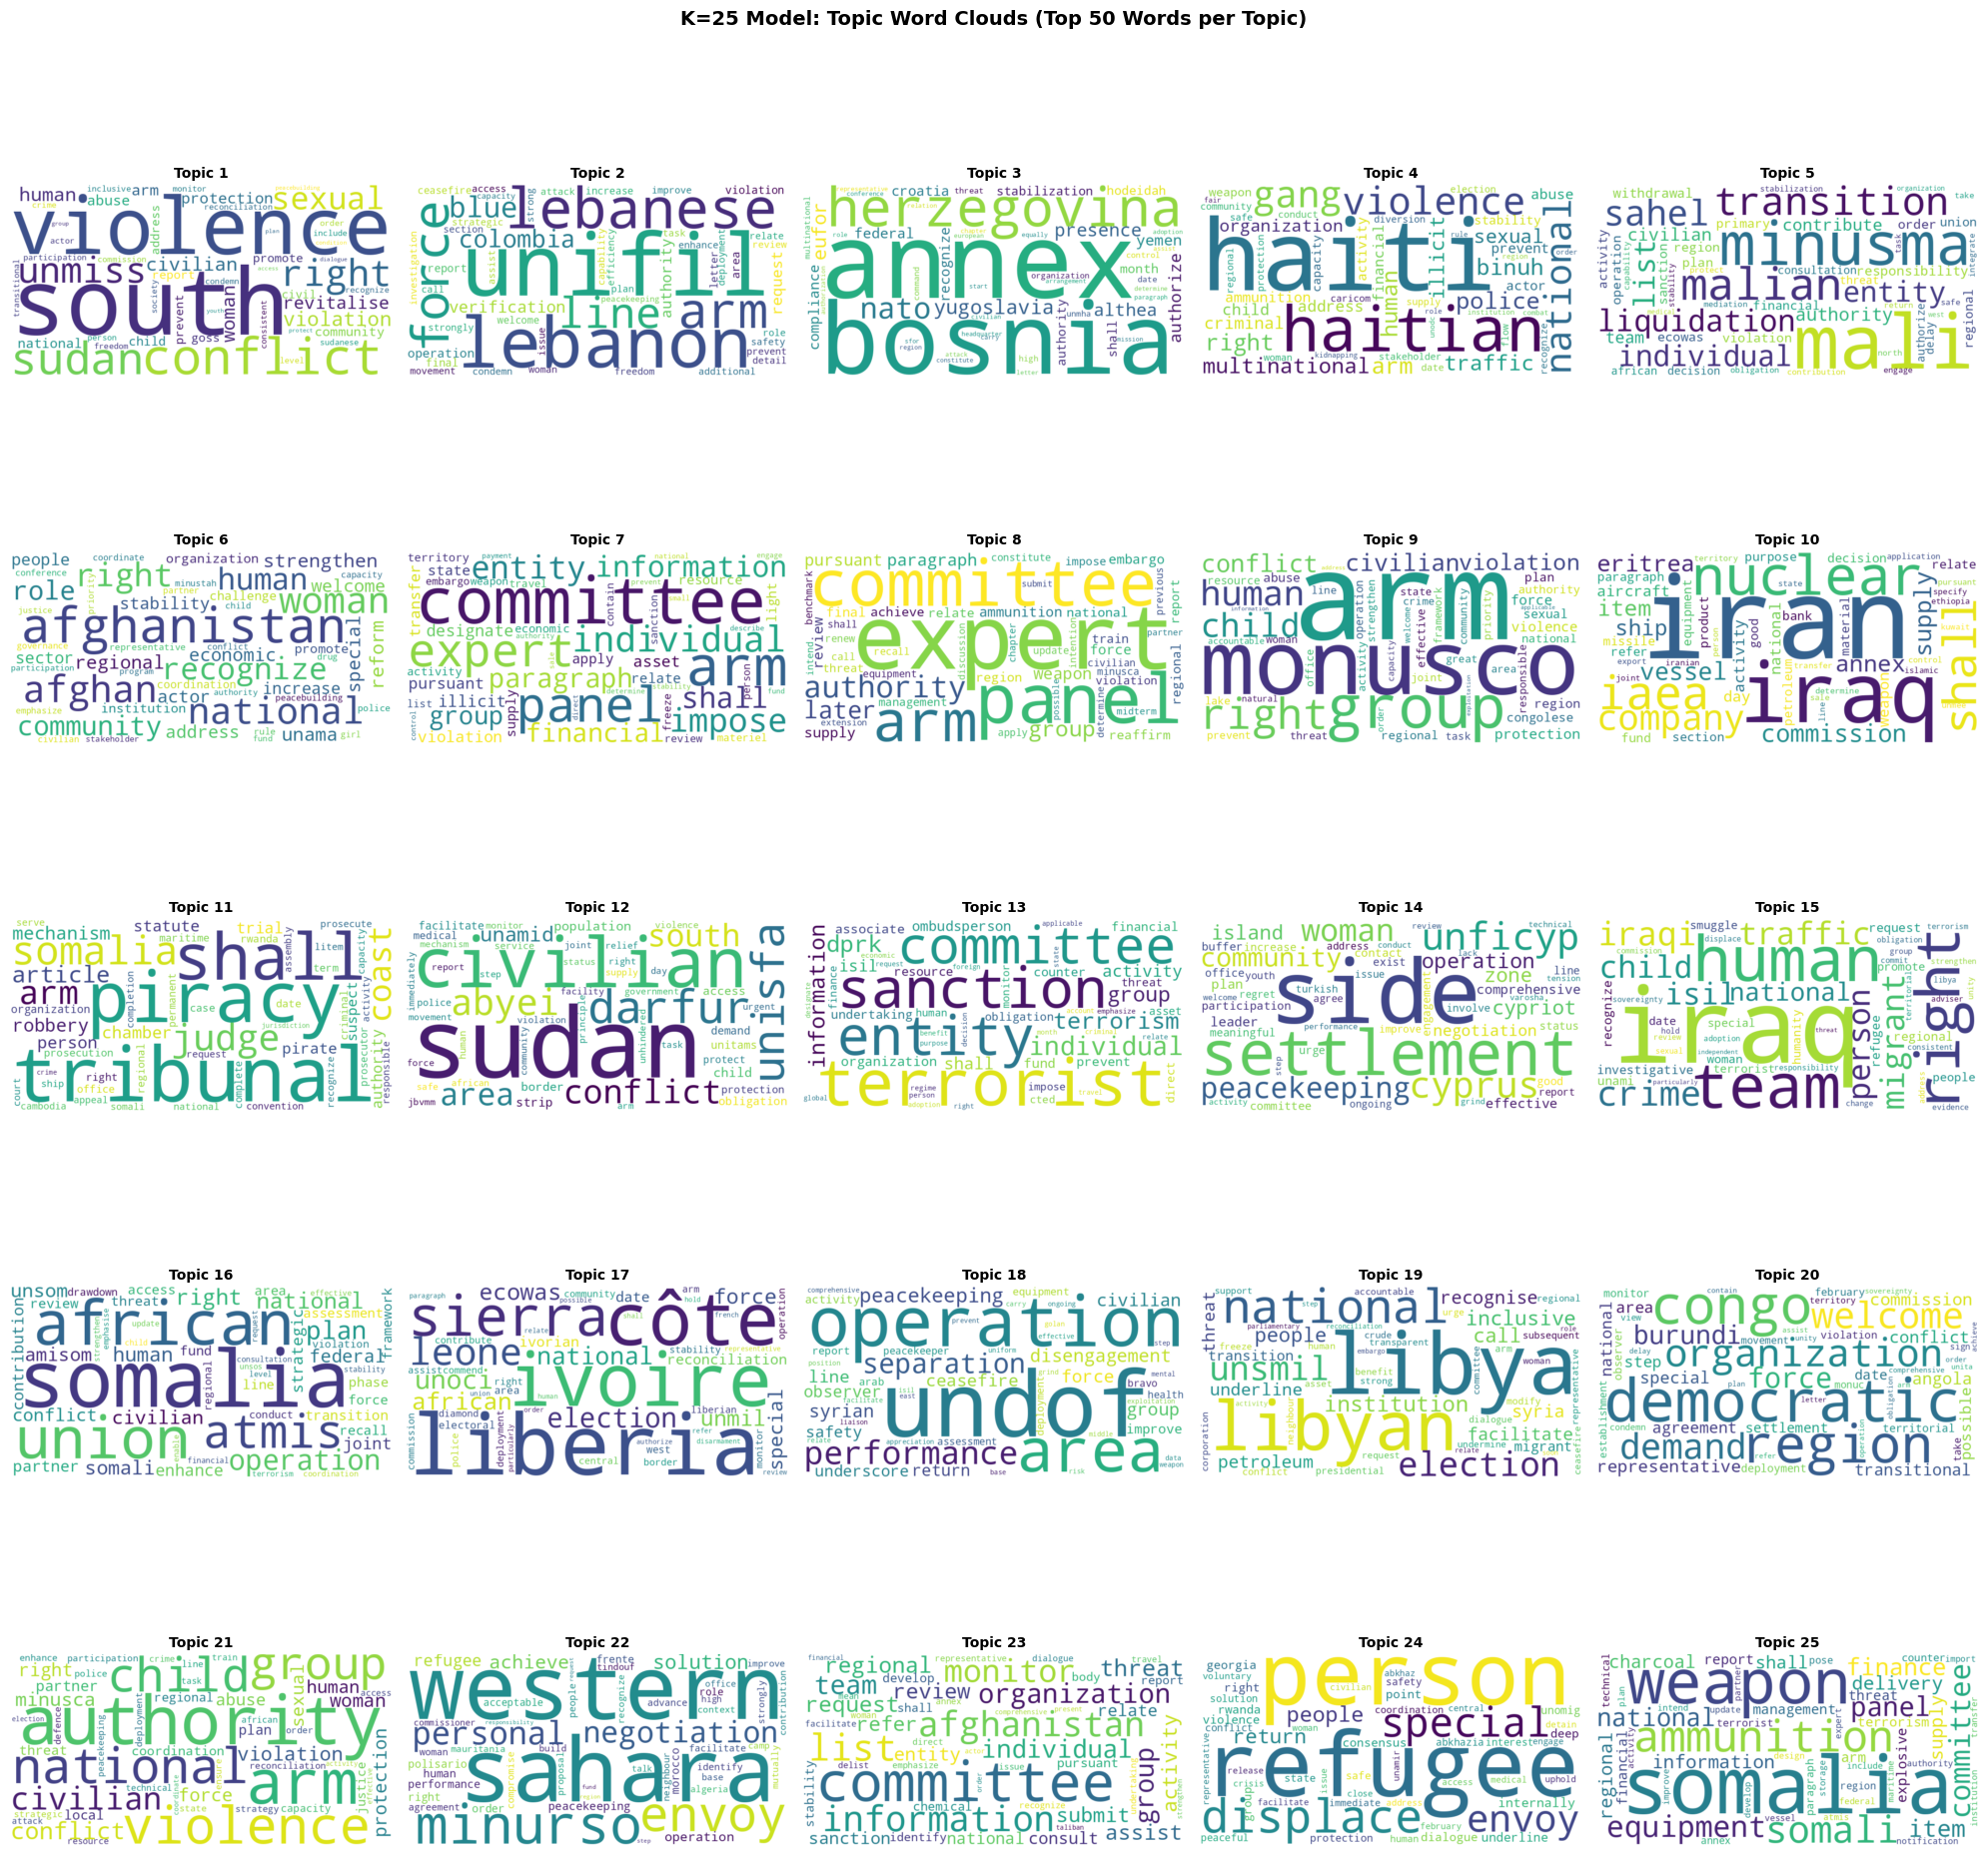

In [18]:
# Create word clouds for K=25 model
fig, axes = plt.subplots(5, 5, figsize=(20, 20))
axes = axes.flatten()

for topic_num in range(25):
    # Get top 50 words for this topic with their probabilities
    topic_words = lda_model_k25.show_topic(topic_num, topn=50)
    
    # Create frequency dictionary for wordcloud (word: probability)
    word_freq = {word: prob for word, prob in topic_words}
    
    # Generate word cloud
    wc = WordCloud(
        width=800, 
        height=400,
        background_color='white',
        colormap='viridis',  # Professional color scheme
        relative_scaling=0.5,
        min_font_size=8,
        max_words=50
    ).generate_from_frequencies(word_freq)
    
    # Plot
    axes[topic_num].imshow(wc, interpolation='bilinear')
    axes[topic_num].axis('off')
    axes[topic_num].set_title(f'Topic {topic_num + 1}', fontsize=10, fontweight='bold')

plt.suptitle('K=25 Model: Topic Word Clouds (Top 50 Words per Topic)', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## Step 9: Visualize Topic Evolution Over Time (Both Models)

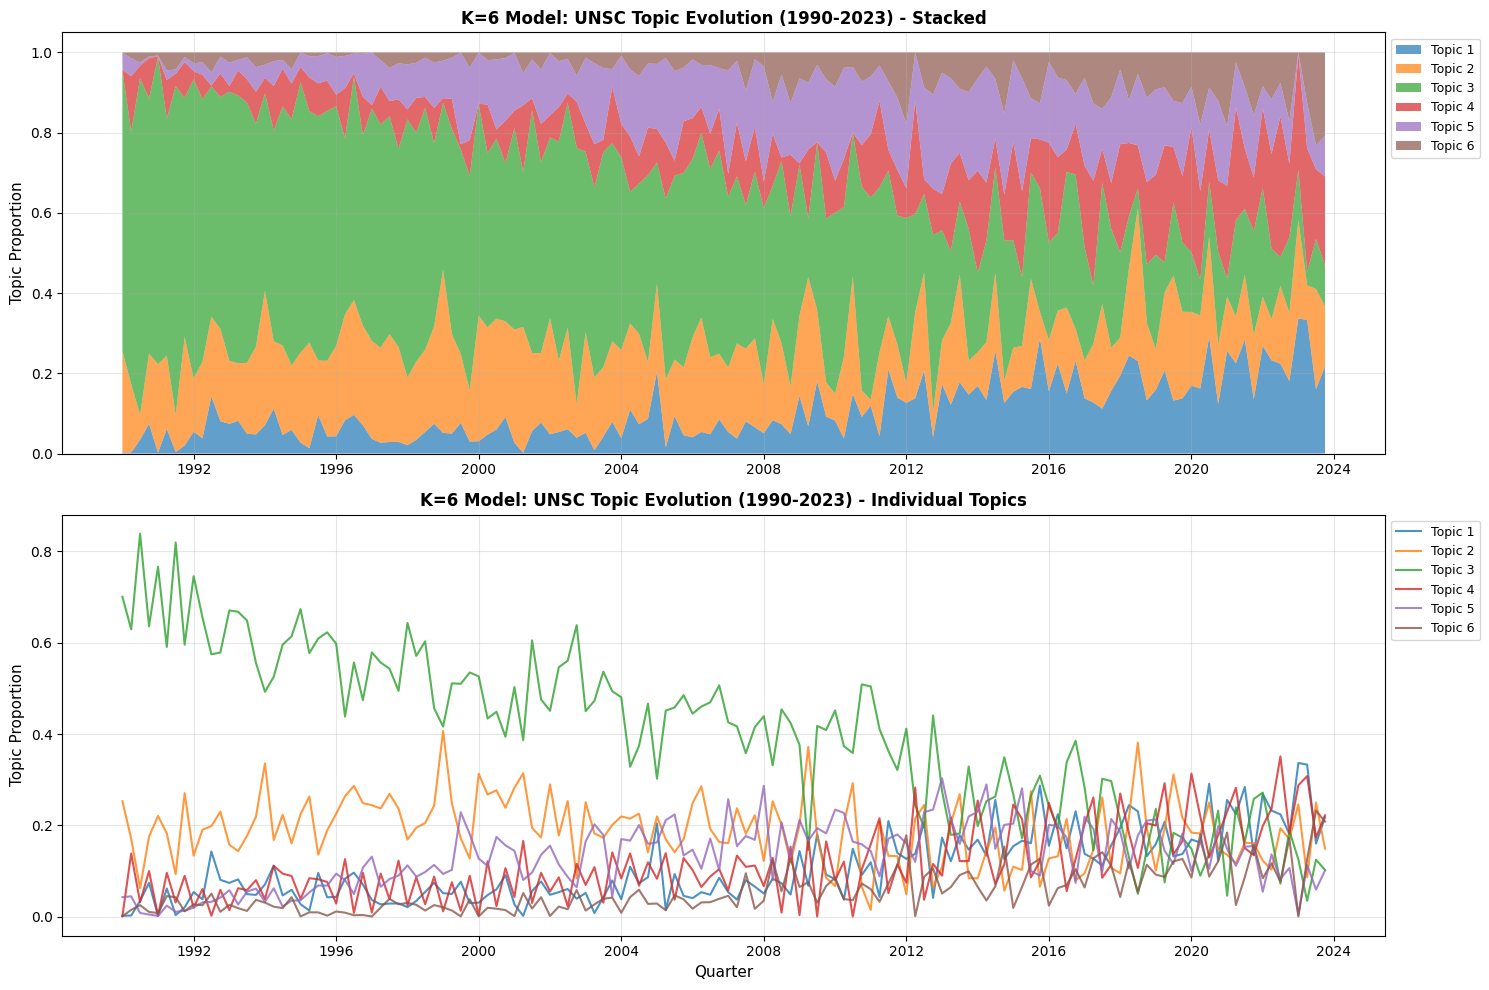

In [19]:
# Plot topic evolution for K=6 model
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Convert to timestamp for plotting
quarters_ts = quarterly_topics_k6.index.to_timestamp()

# Plot 1: All topics stacked area chart
axes[0].stackplot(quarters_ts, 
                  *[quarterly_topics_k6[col] for col in topic_cols_k6],
                  labels=[f'Topic {i+1}' for i in range(6)],
                  alpha=0.7)
axes[0].set_ylabel('Topic Proportion', fontsize=11)
axes[0].set_title('K=6 Model: UNSC Topic Evolution (1990-2023) - Stacked', fontsize=12, fontweight='bold')
axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=9)
axes[0].grid(True, alpha=0.3)

# Plot 2: Individual topic lines
for i, col in enumerate(topic_cols_k6):
    axes[1].plot(quarters_ts, quarterly_topics_k6[col], 
                label=f'Topic {i+1}', linewidth=1.5, alpha=0.8)

axes[1].set_xlabel('Quarter', fontsize=11)
axes[1].set_ylabel('Topic Proportion', fontsize=11)
axes[1].set_title('K=6 Model: UNSC Topic Evolution (1990-2023) - Individual Topics', fontsize=12, fontweight='bold')
axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

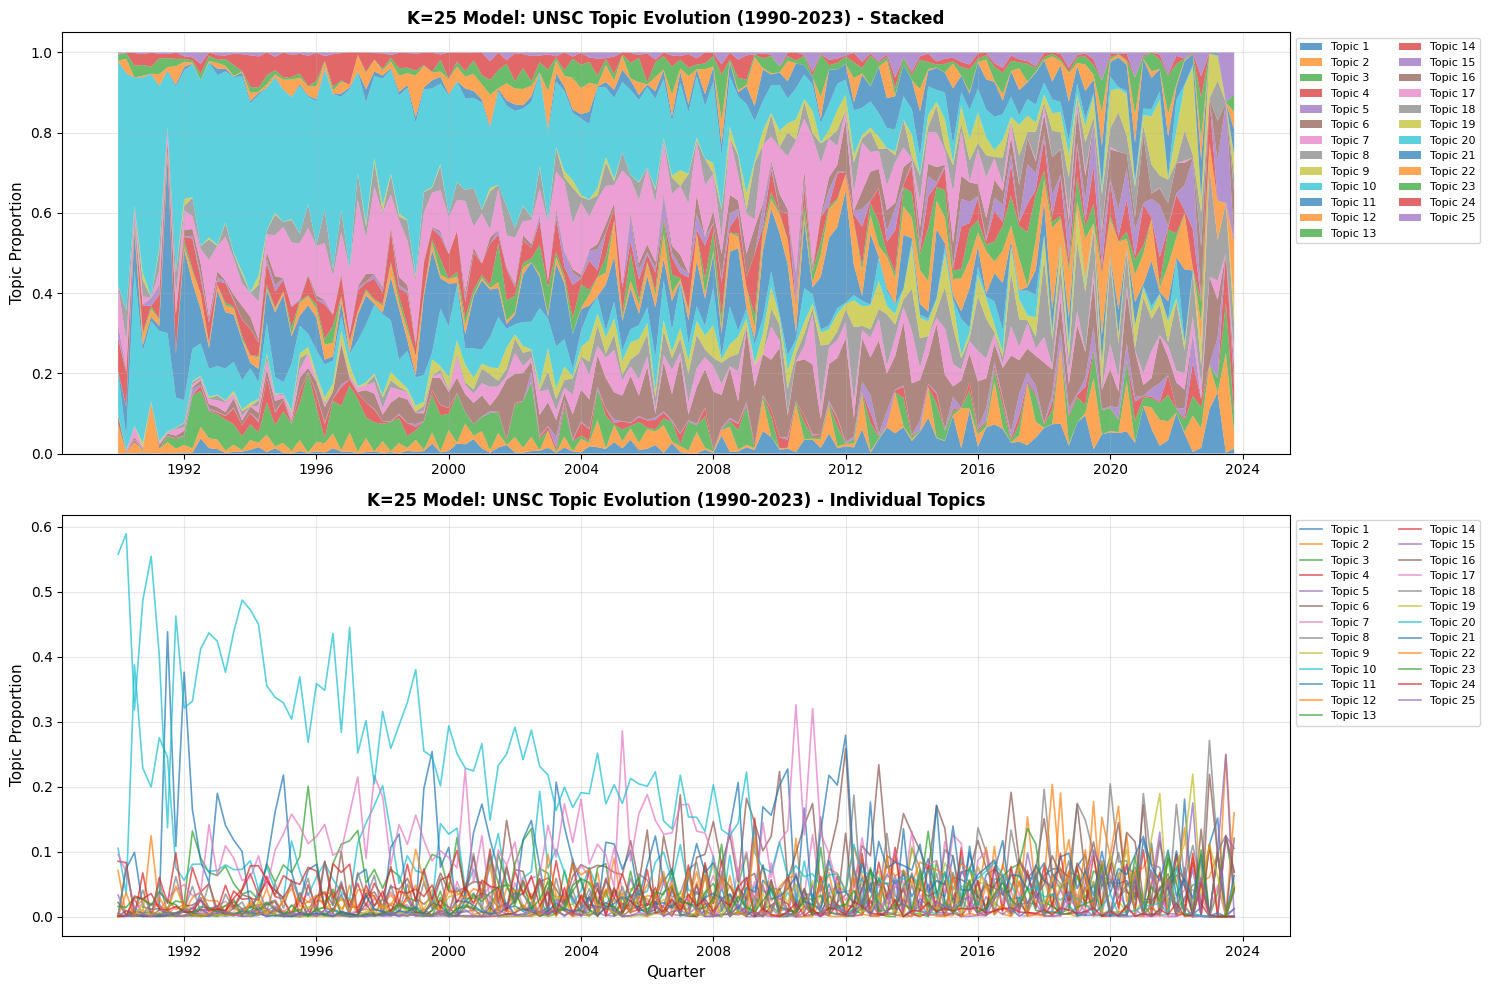

In [20]:
# Plot topic evolution for K=25 model
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Convert to timestamp for plotting
quarters_ts = quarterly_topics_k25.index.to_timestamp()

# Plot 1: All topics stacked area chart
axes[0].stackplot(quarters_ts, 
                  *[quarterly_topics_k25[col] for col in topic_cols_k25],
                  labels=[f'Topic {i+1}' for i in range(25)],
                  alpha=0.7)
axes[0].set_ylabel('Topic Proportion', fontsize=11)
axes[0].set_title('K=25 Model: UNSC Topic Evolution (1990-2023) - Stacked', fontsize=12, fontweight='bold')
axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8, ncol=2)
axes[0].grid(True, alpha=0.3)

# Plot 2: Individual topic lines
for i, col in enumerate(topic_cols_k25):
    axes[1].plot(quarters_ts, quarterly_topics_k25[col], 
                label=f'Topic {i+1}', linewidth=1.2, alpha=0.7)

axes[1].set_xlabel('Quarter', fontsize=11)
axes[1].set_ylabel('Topic Proportion', fontsize=11)
axes[1].set_title('K=25 Model: UNSC Topic Evolution (1990-2023) - Individual Topics', fontsize=12, fontweight='bold')
axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8, ncol=2)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 10: Save Both Topic Models and Features

In [21]:
# Save both models and their topic features
print("=" * 80)
print("SAVING MODELS AND TOPIC FEATURES")
print("=" * 80)

# K=6 Model
print("\n[1/2] Saving K=6 model and features...")
quarterly_topics_k6.to_csv('data/unsc_topics_quarterly_k6.csv')
df_topics_k6.to_csv('data/unsc_topics_resolution_k6.csv', index=False)
lda_model_k6.save('data/lda_model_k6')
print(" Saved:")
print("  - data/unsc_topics_quarterly_k6.csv")
print("  - data/unsc_topics_resolution_k6.csv")
print("  - data/lda_model_k6")

# K=25 Model
print("\n[2/2] Saving K=25 model and features...")
quarterly_topics_k25.to_csv('data/unsc_topics_quarterly_k25.csv')
df_topics_k25.to_csv('data/unsc_topics_resolution_k25.csv', index=False)
lda_model_k25.save('data/lda_model_k25')
print(" Saved:")
print("  - data/unsc_topics_quarterly_k25.csv")
print("  - data/unsc_topics_resolution_k25.csv")
print("  - data/lda_model_k25")

# Save dictionary (shared by both models)
print("\n[3/3] Saving shared dictionary...")
dictionary.save('data/lda_dictionary.dict')
print(" Saved: data/lda_dictionary.dict")

print("\n" + "=" * 80)
print("MODEL SUMMARY")
print("=" * 80)
print(f"K=6 Model:")
print(f"  - Quarterly features: {quarterly_topics_k6.shape}")
print(f"  - Resolution features: {df_topics_k6.shape}")
print(f"\nK=25 Model:")
print(f"  - Quarterly features: {quarterly_topics_k25.shape}")
print(f"  - Resolution features: {df_topics_k25.shape}")
print("\n" + "=" * 80)
print("BOTH MODELS READY FOR FORECASTING ANALYSIS")
print("=" * 80)

SAVING MODELS AND TOPIC FEATURES

[1/2] Saving K=6 model and features...
 Saved:
  - data/unsc_topics_quarterly_k6.csv
  - data/unsc_topics_resolution_k6.csv
  - data/lda_model_k6

[2/2] Saving K=25 model and features...
 Saved:
  - data/unsc_topics_quarterly_k25.csv
  - data/unsc_topics_resolution_k25.csv
  - data/lda_model_k25

[3/3] Saving shared dictionary...
 Saved: data/lda_dictionary.dict

MODEL SUMMARY
K=6 Model:
  - Quarterly features: (136, 6)
  - Resolution features: (2075, 9)

K=25 Model:
  - Quarterly features: (136, 25)
  - Resolution features: (2075, 28)

BOTH MODELS READY FOR FORECASTING ANALYSIS
